- Goal
    - Create synthetic data using IDM
    - Learn parameters of that data using particle filtering
    - Aliter 7 Feb: Learn using CEM idea, fitness function and then distb and then sample
- Feb 10: Adding timegap_des as our 2nd param in the 2 car, 1D, IDM scenario
    - Make code capable of handling 2d param. So far, had only scalar param
    i.e v_des
    - Fitting 2D distributions is required now
- Feb 22
    - the `rec` generated using `simulate` is a devious monster
    - It stores the last timestep in the 1st entry and first timestep in last entry
    - Be careful
- Mar 27
    - Inspired by behavior test written by Maxime to convert this code to work with general scene
    instead of scene1D and state1D as previously
    - Scaling up: scenario is to have 3 different speed vehicles starting in adjacent lanes. Each
    car will have an associated bucket of particles and at the end we whould be able to uncover
    true params for all three cars
    - Disclaimer: This will definitely work since we have confirmed that we can uncover params for one 
    car when it is the leader (i.e. unaffected by any car in front). The current exercise is to scale up the
    code to work with multiple vehicles
    - Idea is that every vehicles associated bucket of particles will evolve differently as it sees more
    of the true trajectory. This is in contrast to original idea where we thought we will have all the buckets
    pooled together to inform the final distribution
- April 4: Some research questions
    - Does the initial velocity of the car impact the learning of the parameters? The test
    we did in the 5 car adjacent lane scenario seemed to do well even with the 
    initial velocity being different from the desired velocity parameter?
    - What situtation will break the vanilla PF but CEM PF will do well
    - How can we add confidence as an information to the output
    provided by the PF?
        - eg: I think v_des should be 25 but not sure because there
        is a car in front that is obstructing me
    - What is the influence of interaction on the filtering results?
    - In the hallucination, does it matter what model we assume to drive
    the other vehicles?
    - Graduate to measuring 2D likelihood when lane changes can start
- April 4: Some todos
    - Fix the seed and write a test that reproduces the parameter
    values estimated from filtering in the 5-car adjacent lane scenario
    - ~~Separate out tests into different files to work with differnt
    functions and `runtests.jl` should just call all these different
    test files~~
    - ~~Visualization functions to compare estimation performance
    over time~~
    - documenter.jl for automatic generation of documentation
- April 5: <span style="color:red"> TODOS </span>
    - Run tons of experiments and give result to see whether or not we are getting
    one off good results or can we truly test the results
- April 6: Discovery
    - Starting the cars from 0 velocity makes the particle filter estimate go off kilter
    - Starting from the v_des true param value makes it work fine
    - As seen from the one lane 2 car scenario
- April 7: Verbal description of what the particle filter is doing
    - Start with a bucket for each car. Each bucket contains 100 particles. Each particle is a
    dictionary with parameter, value pairing eg: v_des, 20.0
    - Hallucinate a step using each particle. Compare hallucination against ground truth to get
    relative goodness between every particle
        - This is done by measuring the likelihood of the true data under a _Gaussian_ distribution that
        is centered around the hallucinated position and has a standard deviation that is
        proportional to the timestep standard deviation $\sigma_{pos} = \Delta T^2*\sigma_{acc}$
        (note that $\sigma_{acc}$ is a parameter of IDM)
            - <span style="color:blue">_Is this too naive a way to measure likelihood i.e. will
    it capture influence on params such as Timegap and Min. allowable distance_</span>
            - <span style="color:blue">_Is a Gaussian distribution the best to do this 
    likelihood computation?_</span>
    - Particle filter
        - Resample from the set of particles using weights obtained using above relative goodness
        to obtain 100 new particles
    - Cross entropy method
        - Fit a distribution after selecting elites from the set of particles according to relative
        goodness
        - Sample 100 new particles from this distribution
    - Once the entire trajectory has been seen, every car has an associated bucket that contains
    100 particles
- April 8: 
    - ~~<span style="color:red">TODO Function that does both particle bucket returning and captures RMSE progress with time</span>~~
    - Implemented `zero_dict`, `mean_dict`, `particle_difference_paramwise` 
    functions to scale up to return parameter wise error with iter num
- April 9:
    - Implemented `compute_mean_dict`, `init_empty_array_dict`, `combine_array_dicts`,`plot_dict`
- April 11:
    - Implemented method to do estimation and then rmse position to evaluate imitation performance

In [1]:
using AutomotiveDrivingModels;using AutoViz;using Reel
using Interact;using StatsBase # For weights function used by particle filter
using Test;using Distributions;using Pkg;using PyPlot;
using LinearAlgebra # For norm calculation

HTML{String}("    <script class='js-collapse-script'>\n        var curMatch =\n            window.location.href\n            .match(/(.*?)\\/notebooks\\/.*\\.ipynb/);\n\n        curMatch = curMatch ||\n            window.location.href\n            .match(/(.*?)\\/apps\\/.*\\.ipynb/);\n\n        if ( curMatch ) {\n            \$('head').append('<base href=\"' + curMatch[1] + '/\">');\n        }\n    </script>\n")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ac92513fc97126f4d4502d0637c43de8cdb5fca9-assets/webio/dist/bundle.js'></script>")

HTML{String}("<script class='js-collapse-script' src='/assetserver/ac92513fc97126f4d4502d0637c43de8cdb5fca9-assets/providers/ijulia_setup.js'></script>")

HTML{String}("  <script class='js-collapse-script'>\n    \$('.js-collapse-script').parent('.output_subarea').css('padding', '0');\n  </script>\n")

In [2]:
include("admin_functions.jl")
include("driving_functions.jl")
include("filtering_functions.jl")
include("metrics_functions.jl");

In [ ]:
# List the available functions loaded from the above include statements
# https://stackoverflow.com/questions/21301451/get-a-list-of-current-variables-in-julia-lang
names(Main)[4:end]

# Workspace

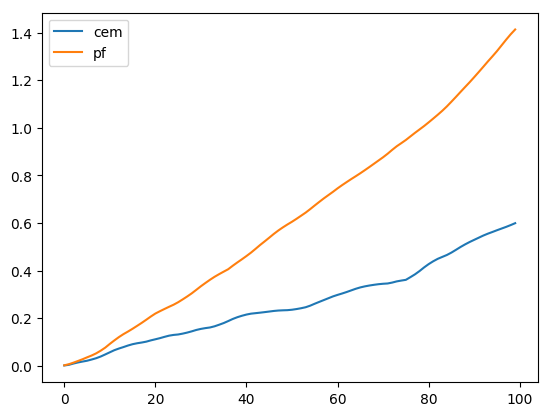

PyObject <matplotlib.legend.Legend object at 0x7fcc84102c18>

In [44]:
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
rmse_pos_array_cem = estimate_then_evaluate_imitation(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem")
rmse_pos_array_pf = estimate_then_evaluate_imitation(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="pf")
plot(rmse_pos_array_cem,label="cem")
plot(rmse_pos_array_pf,label="pf")
legend()

# Recent Work

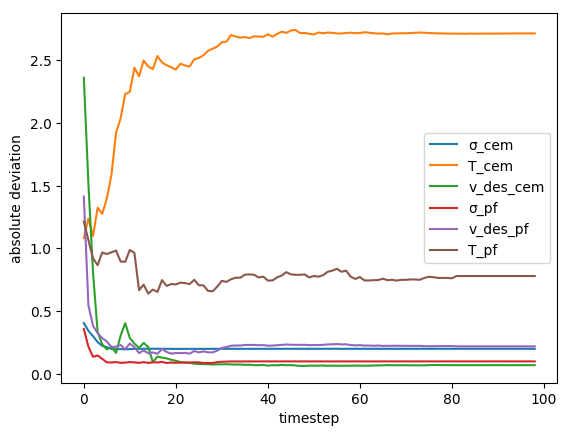

In [7]:
# 5 cars adjacent lanes scenario with 3 parameters
# Parameter wise result plotting with both cem and pf in same plot
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2,:T=>1.5);d2 = Dict(:v_des=>20.0,:σ=>0.3,:T=>1.5);
d3 = Dict(:v_des=>15.0,:σ=>0.,:T=>1.5);d4 = Dict(:v_des=>18.0,:σ=>0.4,:T=>1.5);
d5 = Dict(:v_des=>27.0,:σ=>0.2,:T=>1.5)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.),(:T,0.1,0.1,5.)]
rmse_array_pf = capture_filtering_progress_paramwise(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="pf")
rmse_array_cem = capture_filtering_progress_paramwise(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem");
pf_array = combine_array_dicts(rmse_array_pf);
cem_array = combine_array_dicts(rmse_array_cem);
res = combine_exp_results_dicts([:cem,:pf],[cem_array,pf_array])
plot_dict(res)
xlabel("timestep")
ylabel("absolute deviation");

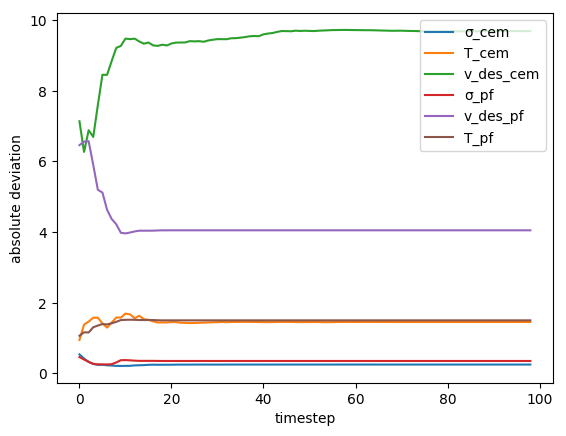

In [15]:
# 2 cars in the same lane scenario with 3 parameters
# Parameter wise result plotting with both cem and pf in same plot
num_particles = 100
pos_vel_array_1 = [(30.,18.),(10.,12.)]
lane_place_array = [pos_vel_array_1]
num_cars = 2
d1 = Dict(:v_des=>20.0,:σ=>0.1,:T=>1.5);d2 = Dict(:v_des=>10.0,:σ=>0.1,:T=>1.5)
car_particles = [d1,d2]
particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.),(:T,0.1,0.1,5.)]
rmse_array_pf = capture_filtering_progress_paramwise(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="pf")
rmse_array_cem = capture_filtering_progress_paramwise(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem");

pf_array = combine_array_dicts(rmse_array_pf);
cem_array = combine_array_dicts(rmse_array_cem);
res = combine_exp_results_dicts([:cem,:pf],[cem_array,pf_array])
plot_dict(res)
xlabel("timestep")
ylabel("absolute deviation");

# Legacy

In [ ]:
# 5 cars adjacent lanes scenario with 2 parameters
# Combines all paramters into one mean error metric and plots that
# Cem and pf appear as different lines on the plot
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
rmse_array_pf = capture_filtering_progress(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="pf")
rmse_array_cem = capture_filtering_progress(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem")
plot(rmse_array_pf,label="particle filter")
plot(rmse_array_cem,label="cross entropy method")
legend()
xlabel("Timestep along true data trajectory")
ylabel("Mean parameter error")

In [ ]:
# 2 cars in the same lane scenario with 2 parameters
num_particles = 100
pos_vel_array_1 = [(30.,15.),(10.,15.)]
lane_place_array = [pos_vel_array_1]
num_cars = 2
d1 = Dict(:v_des=>20.0,:σ=>0.1);d2 = Dict(:v_des=>10.0,:σ=>0.1)
car_particles = [d1,d2]
particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
bucket_array = filter_particles_over_trajectory(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem")
print_buckets_mean(bucket_array)

In [ ]:
# 5 cars adjacent lanes scenario with 2 parameters
num_particles = 100
lane_place_array = [[(0.,10.)],[(0.,20.)],[(0.,15.)],[(0.,20.)],[(0.,20.)]]
num_cars = 5
d1 = Dict(:v_des=>10.0,:σ=>0.2);d2 = Dict(:v_des=>20.0,:σ=>0.3);d3 = Dict(:v_des=>15.0,:σ=>0.)
d4 = Dict(:v_des=>18.0,:σ=>0.4);d5 = Dict(:v_des=>27.0,:σ=>0.2)
car_particles = [d1,d2,d3,d4,d5]

particle_props = [(:v_des,10.,0.1,30.),(:σ,0.1,0.1,1.)]
bucket_array = filter_particles_over_trajectory(num_particles,num_cars,lane_place_array,
    car_particles,particle_props,approach="cem")
print_buckets_mean(bucket_array)

# Visualize

In [ ]:
# Function: Return rec corresponding to generated traj
    # Will help visualizatoin
    # Calls init_scene
# Might be useful later
    # models[2] = IntelligentDriverModel(v_des=particle[1],s_min=particle[2],T=particle[3])
function gen_rec4vid(particle;nticks=100,timestep=0.1)
    scene = init_scene()
    models = Dict{Int, LaneFollowingDriver}()
    models[1] = IntelligentDriverModel(v_des=particle[1],σ = particle[2])
    models[2] = IntelligentDriverModel(v_des=12.0)

    # Simulate for nticks (default 100) time steps
    timestep = 0.1
    rec = QueueRecord(Vehicle1D, nticks+1, timestep)
    simulate!(LaneFollowingAccel, rec, scene, roadway, models, nticks)

    return rec
end

In [ ]:
# overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true,
#         pos=VecE2(veh.state.s-0.7, 3)) for veh in scene];
# render(scene, roadway, overlays, cam=cam, canvas_height=100)

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
true_rec = gen_rec4vid([20.0 0.1],nticks=100)
rec = true_rec
@manipulate for frame_index in 1 : nframes(rec)
    render(rec[frame_index-nframes(rec)], roadway, cam=cam, canvas_height=100)
end

# LEARNING AND EXPERIMENTATION

In [ ]:
# LEARNING ABOUT MULTIDIM DISTB
# Test: Generate samples for a 2d distb
d2 = MvNormal(2,2.0) # first arg shows dimension, second shows std dev
qw = rand(d2,6) # Will generate 6 samples i.e. 6 columns

# Test: Fit 2d distribution
dx = Normal()
dy = Normal(2,1.0)
x = rand(dx,100)
y = rand(dy,100)

# Matrix with each column being a sample
# Total columns is total number of samples
# Total rows is number of parameters
# All entries in a row contain value from same param eg:v_des
data_matrix = vcat(x',y')
fit(MvNormal,data_matrix)

In [ ]:
using PyPlot

In [ ]:
num_samples = 2000
y1 = rand(Normal(10.0,5.0),num_samples)
y2 = rand(Normal(2.0,1.0),num_samples)
plot(1:num_samples,y1)
plot(1:num_samples,y2)

In [ ]:
using StatPlots

In [ ]:
StatPlots.plot(Normal(3,5),linewidth=4,size=(2500,2500))

In [ ]:
roadway = gen_straight_roadway(2,1000.0);

In [ ]:
scene = Scene1D()
push!(scene, Entity(State1D(10.0,  8.0), VehicleDef(), 1))
push!(scene, Entity(State1D(50.0, 12.5), VehicleDef(), 2))

cam = StaticCamera(VecE2(100.0,0.0), 4.75)
overlays = [TextOverlay(text=["$(veh.id)"], incameraframe=true, pos=VecE2(veh.state.s-0.7, 3)) for veh in scene]
render(scene, roadway, overlays, cam=cam, canvas_height=100)